# Lab 4 : Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *lucca.guardiola@centralesupelec.fr* by November 12, 2020 and put **"AML-NMF"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# NMF - Recap

Non-negative Matrix Factorization is a model where a matrix X is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.


Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999] (http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

\begin{array}{c}
W \leftarrow W .* \left(X H^T\right)./W \left(H H^{\top} + {\color{red} \nu I_r}\right) \\
H \leftarrow H .* \left(W^{\top} X - {\color{red} \lambda 1_{r \times n}}\right)./\left((W^{\top} W + {\color{red} \mu I_r})H\right)
\end{array}


.* is the dot product ( in python  : A*B ) 

AB is the matrix product ( in python : A@B )

## Initialization 

The computation time and the convergence of the NMF depends on how you initialize the matrices W and H.
You will implement and compare two types of initialization. 

#### Random initialization : 

$\forall i,j, H^0_{i,j}\sim U_{[0,1]}$ and $ W^0_{i,j}\sim U_{[0,1]} $

Each term of $W^0$ and $H^0$ is sampled with a uniform distribution. Use np.random.random(Matrix_shape)

#### NNDSVD initialization : 

Singular value decomposition (SVD) is a classical method that extends the eigen-decomposition to non-square matrix.

For any $ X \in \mathbb{R}^{N\times M}$, there exists a factorization with the following form:

$$ X = U \Sigma V^T $$

With $ U \in \mathbb{R}^{N\times N} , \Sigma  \in \mathbb{R}^{N\times M} \text{ such as } \Sigma = \begin{pmatrix} 
\Sigma_1 & 0 \\
0 & 0 
\end{pmatrix} , V \in \mathbb{R}^{M\times M} $



$\Sigma_1 = diag(σ1, σ2, ..., σr)$, and the diagonal entries are sorted in descending order, i.e. σ1 ≥ σ2 ≥ ... ≥ σr > 0,
σi, i = 1, 2, ...r being the singular values with r = rank(Z)


After the computation of the SVD of X, the initialization of W and H is made with  

$$ W^0 = |U_{:,:r}|$$
$$ H^0 = | \Sigma_{:r,:}V^T| $$ 
$|.|$ means the absolute value for each term of the matrix, r = number of components of the NMF :

You will need : 
np.linalg.svd 

Watch out np.linalg.svd returns only the diagonal of $\Sigma$. I advise you ton create a empty matrix $\Sigma$ with np.zeros(Shape of the matrix) then fill the diagonal with np.diag(). You can use the exemple in https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html



### Tasks  :  
- Fill the fit transform function. Consider $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}$ (no regularization)
- Implement NNSVD initialization and random initialization. 
- Return W H and the Froebenius norm of the residuals (the loss) when the convergence condition is fulfilled.

(This should take you less than 30 minutes)

In [2]:
class my_NMF():
    def __init__(self, n_components, epsilon,init, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_ : float
        init_ :  {"random", "NNDSVD"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components = n_components
        self.max_iter = max_iter
        #self.loss = loss
        self.epsilon = epsilon
        self.init = init
        self.W = None
        self.H = None
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        W,H,loss
        """        


        
        
        if self.init == 'NNDSVD' : 
            #TODO
            #Initialize W and H with a SVD of X
            U, s, V = np.linalg.svd(X)
            S = np.zeros(X.shape)
            S[:X.shape[0], :X.shape[0]] = np.diag(s)
            self.W = np.abs(U[:,:self.n_components])
            self.H = np.abs(S[:self.n_components, :] @ V.T)


            
        elif self.init == 'random' :
            #TODO
            #Initialize W and H by generating uniform samples.
            self.W = np.random.rand(X.shape[0], self.n_components)
            self.H = np.random.rand(self.n_components, X.shape[1])

        
        convergence = False 
        n_iter = 0
        
        while not(convergence) : 
            #The convergence is reached when the number of iteration is equal to self.max_iter or
            #when the loss < self.epsilon
            #TODO 
            #Update W and H for each iteration
            self.W = self.W * (X @ self.H.T) / (self.W @ self.H @ self.H.T)
            self.H = self.H * (self.W.T @ X) / (self.W.T @ self.W @ self.H)
            
            n_iter += 1
            loss = np.linalg.norm(X - self.W @ self.H)
            convergence = (
                (n_iter == self.max_iter) or
                (loss < self.epsilon)
            )
        
        return self.W,self.H,loss


### Bonus : Implement the regularized version

In [3]:
class my_reg_NMF():
    def __init__(self, n_components, epsilon,init, mu, lam, nu, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_ : float
        init_ :  {"random", "NNDSVD"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components = n_components
        self.max_iter = max_iter
        #self.loss = loss
        self.epsilon = epsilon
        self.init = init
        self.mu = mu
        self.lam = lam
        self.nu = nu
        self.W = None
        self.H = None
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        W,H,loss
        """        


        
        
        if self.init == 'NNDSVD' : 
            #TODO
            #Initialize W and H with a SVD of X
            U, s, V = np.linalg.svd(X)
            S = np.zeros(X.shape)
            S[:X.shape[0], :X.shape[0]] = np.diag(s)
            self.W = np.abs(U[:,:self.n_components])
            self.H = np.abs(S[:self.n_components, :] @ V.T)


            
        elif self.init == 'random' :
            #TODO
            #Initialize W and H by generating uniform samples.
            self.W = np.random.rand(X.shape[0], self.n_components)
            self.H = np.random.rand(self.n_components, X.shape[1])

        
        convergence = False 
        n_iter = 0
        
        while not(convergence) : 
            #The convergence is reached when the number of iteration is equal to self.max_iter or
            #when the loss < self.epsilon
            #TODO 
            #Update W and H for each iteration
            one_matrix = np.ones((self.n_components, X.shape[1]))
            #import pdb; pdb.set_trace()
            self.W = self.W * (X @ self.H.T) / (self.W @ self.H @ self.H.T + self.nu * self.W)
            self.H = self.H * (self.W.T @ X - self.lam * one_matrix) / (self.W.T @ self.W @ self.H + self.mu * self.H)
            
            n_iter += 1
            loss = np.linalg.norm(X - self.W @ self.H)
            convergence = (
                (n_iter == self.max_iter) or
                (loss < self.epsilon)
            )
        
        return self.W,self.H,loss



## Applications

### First application - Images

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

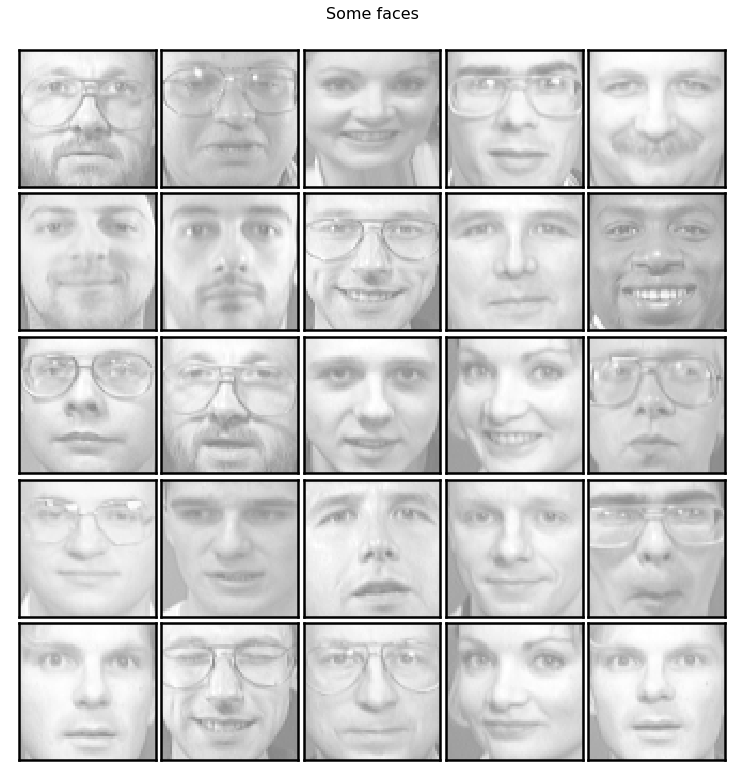

In [4]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

### Task : apply your NMF algorithm to this dataset and plot the approximated face pictures. Compare the different initializations

#### Random Initialization

119.74513417150631


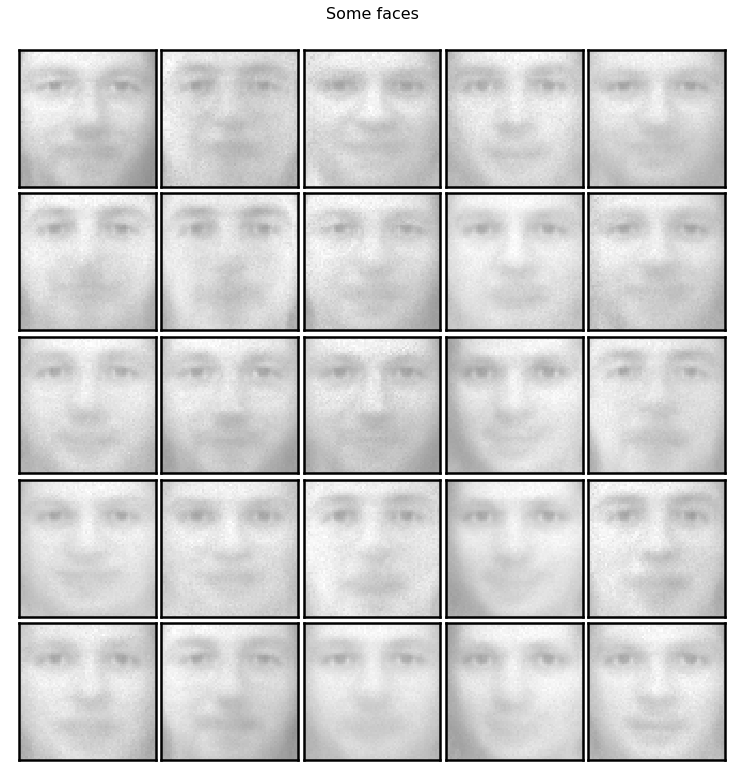

In [5]:
# TODO 
nmf = my_NMF(n_components=50, epsilon=10,init="random")
W, H, loss = nmf.fit_transform(faces)

faces_nmf = W @ H
faces_nmf.shape

image_shape = (64, 64)

n_samples, n_features = faces_nmf.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces_nmf[:25], image_shape)

print(loss)

106.39805780230557


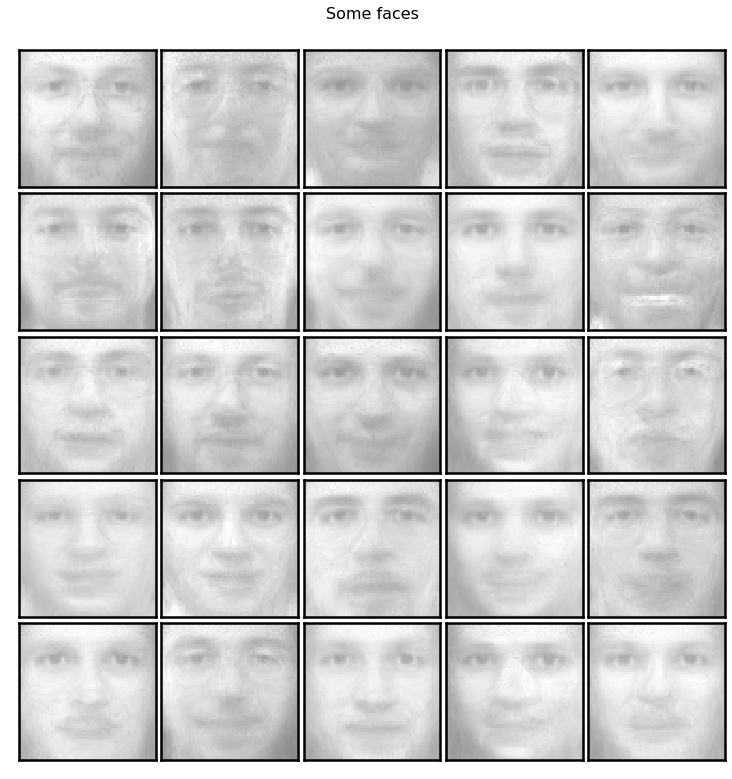

In [6]:
# TODO 
nmf = my_NMF(50, 10, init="NNDSVD")
W, H, loss = nmf.fit_transform(faces)

faces_nmf = W @ H
faces_nmf.shape

image_shape = (64, 64)

n_samples, n_features = faces_nmf.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces_nmf[:25], image_shape)

print(loss)

### Tasks :  
- Apply NMF with the SVD initialisation and with a number of components r such as $\sqrt r$ is an integer (r = 4,16,etc..) 
- Plot the $H$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid ( n_col=n_row=$\sqrt r $)
- Choose one face, plot its corresponding weights (in $W$) in a grid 
- How can we interpret the matrices H and W.

Be careful with the arguments image_shape, n_col n_row in the plot_faces function

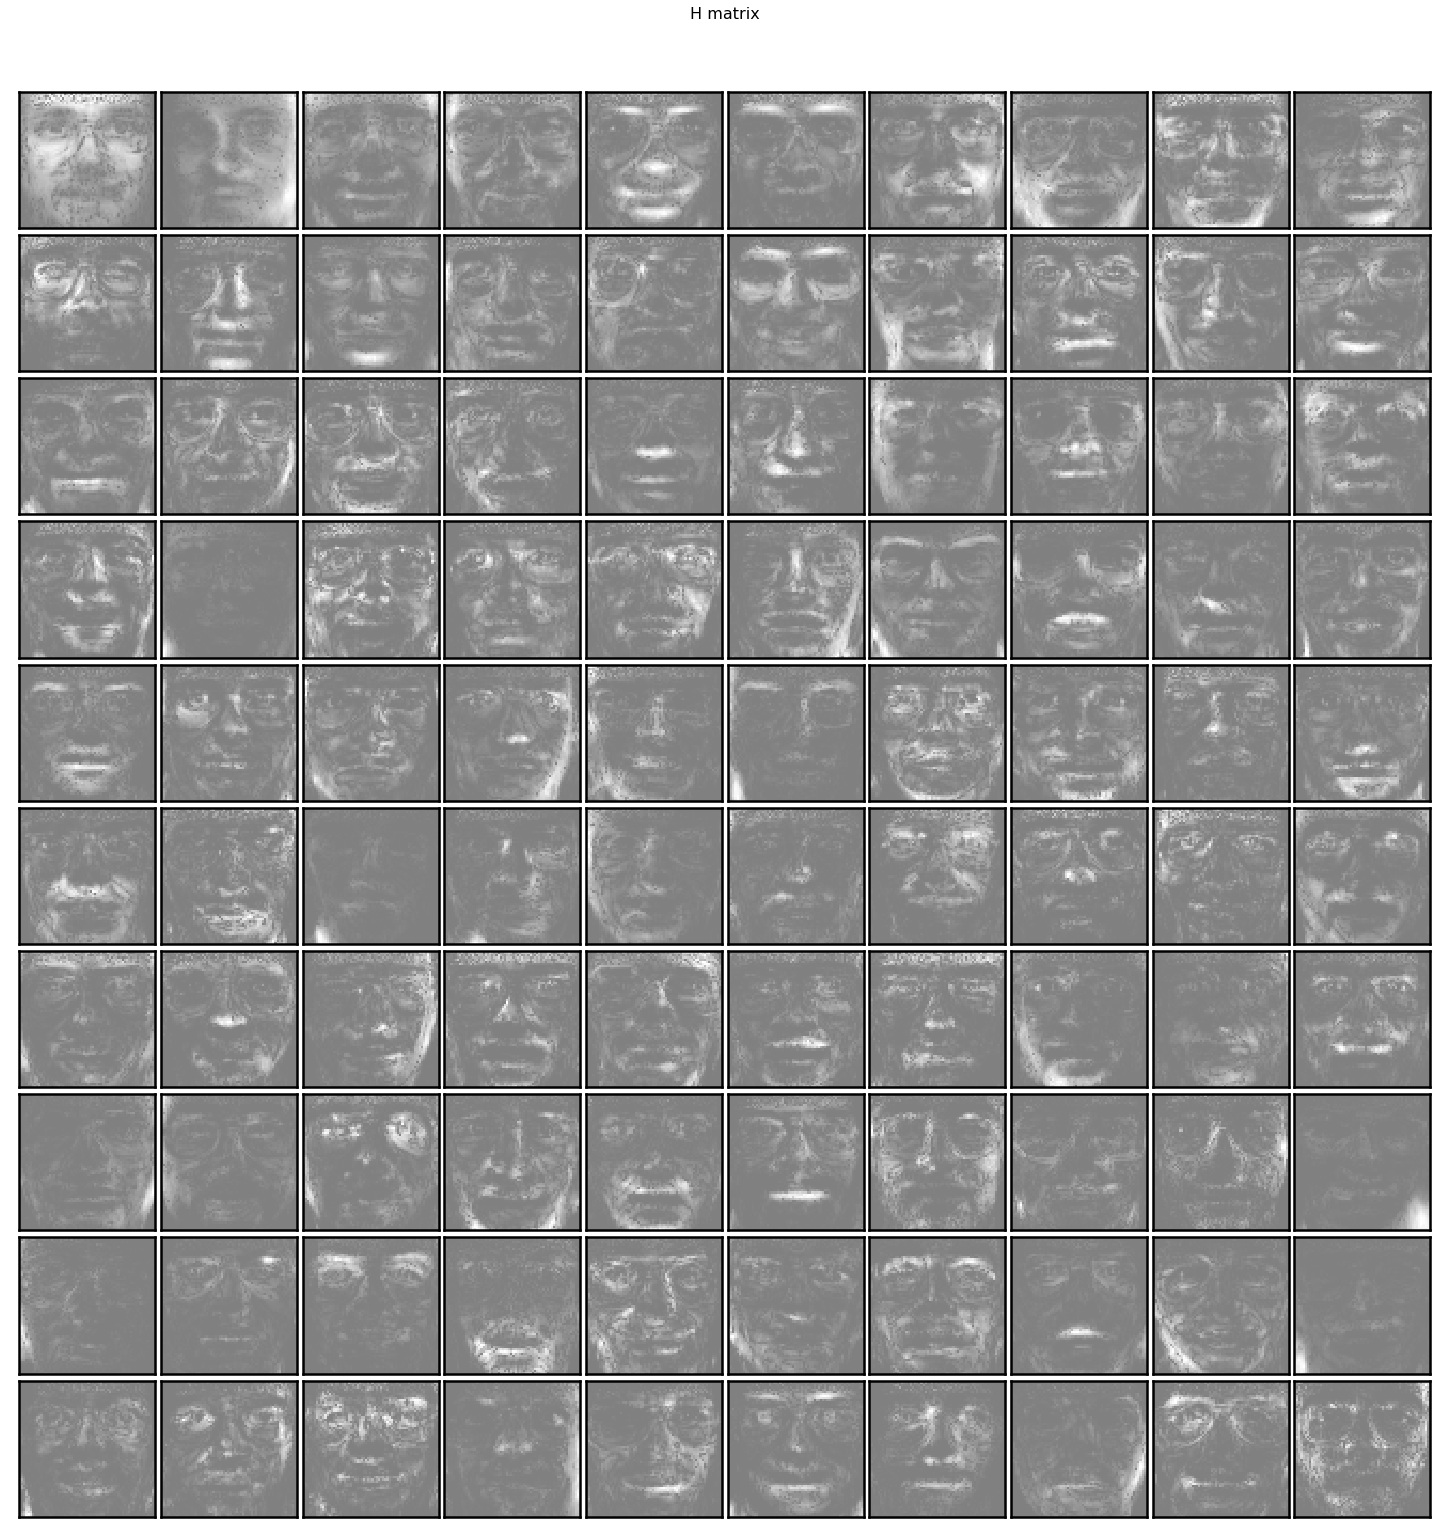

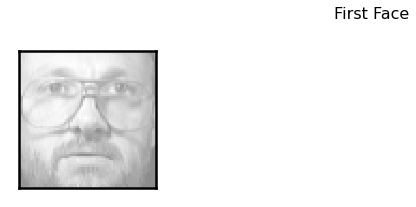

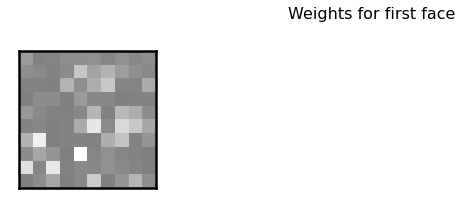

In [7]:
#TODO
r = 10**2
nmf = my_NMF(r, 10, init="NNDSVD", max_iter=100)
W, H, loss = nmf.fit_transform(faces)


plot_faces("H matrix", H, (64,64), n_col=np.sqrt(r), n_row=np.sqrt(r))

plot_faces("First Face", faces[:1], (64,64))

plot_faces("Weights for first face", W[:1], (int(np.sqrt(r)),int(np.sqrt(r))))

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 news documents from 20 different newsgroups (i.e 20 different topics like art news, geopolitical news etc...)

The goal of this exercice is to model the topics present with NMF then print the most common words of each topic.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 5000
n_features = 2000
n_components = 10
n_top_words = 20

def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [9]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


print(data_samples[:3]) # A few exemple of news 

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n", "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap 

### Feature extraction/engineering 

Before applying NMF, you have to convert text into numerical values in order to vectorize your documents.

We will be looking at the Count vectorizer method and the TF-IDF vectorizer.

### Count vectorizer. 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

We define a corpus by an ensemble of documents $(D_1,...D_N)$. From this corpus we collect all the different words used in the documents, this collection of words $(w_1,...w_p)$ is called the vocabulary of the corpus.

Using the count vectorizer, the numerical representation of a document $D_i$ will be Count_Vectoriser$(D_i) = \sum_{j=1}^p f_{ij}w_j $ With f_ij, the frequency of appearence of the word $w_j$ in the document $i$.

### TF-IDF

Task : Search for TF-IDF. Explain its principle and its difference with count_vectorizer

Answer : 
TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus \
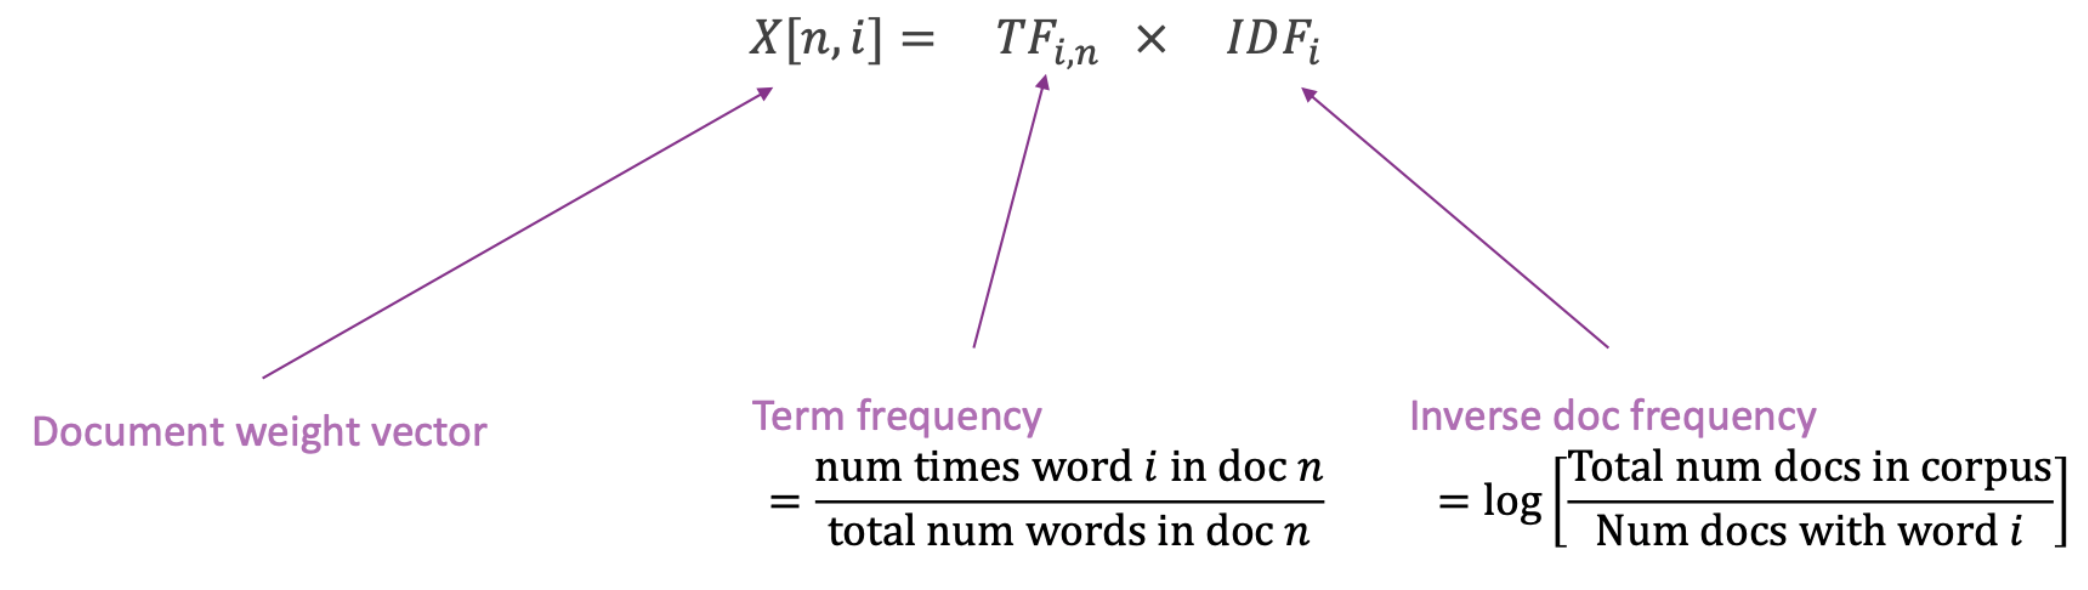

So CountVectorizer is only the TF part of TF-IDF and therefore it results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.

### Task : Vectorize your document with Count Vectorizer or TF-IDF. 
#### Put in argument stop_words='english'  and max_features=n_features 
Stop_words is a list of common words that don't bring any information like 'the', 'a' etc... We don't want these words to take up space in our database for computation time reason and because they could harm the numerical representation of the documents. 

You must obtain a $5000\times2000$ shaped matrix 

In [10]:
# TODO
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( 
    max_df=0.5, # max doc freq (as a fraction) of any word to include in the vocabulary
    min_df=2,   # min doc freq (as doc counts) of any word to include in the vocabulary
    max_features=n_features,           # max number of words in the vocabulary
    stop_words='english',         # remove English stopwords
    use_idf=True )        # use IDF scores
tfidf = tfidf_vectorizer.fit_transform(data_samples)


### Task : Apply NMF from sklearn with a choosen initialization. Then print the top words for each topics with print_top_words

Use tfidf_vectorizer.get_feature_names() to recover the words. 

In [11]:
from sklearn.decomposition import NMF

In [12]:
# Fit the NMF model
nmf = NMF(n_components=n_components).fit(tfidf)


print_top_words(nmf.components_.T, tfidf_vectorizer.get_feature_names(), n_top_words)

Topic #0: don just people think like know right good ve did really way make time say going want things thing said
Topic #1: thanks does know mail advance hi info anybody looking email help appreciated information interested post like reply need send list
Topic #2: god jesus bible faith christians christ christian believe does church lord heaven life love say true father son truth sin
Topic #3: key chip encryption keys clipper government law use escrow public enforcement security data phone nsa algorithm encrypted number information bit
Topic #4: space nasa launch shuttle gov earth orbit data moon sci science lunar program years long research cost time mission center
Topic #5: 00 sale new 10 price shipping car 50 20 offer 15 condition 25 30 12 brand asking sell interested 40
Topic #6: windows file dos use files problem using program window screen card running pc drivers ms graphics run application version server
Topic #7: game team year games play players season hockey league win nhl te

The relevance of the topics can be improved with better parameters in the vectorizer, a more advanced cleaning in addition to the stopwords (for instance getting rid of the numbers etc ...) or more advanced vectorizer/encoder like Word2Vec or Doc2Vec which use very simple neural networks. 

### Imagine we would like to gather the news coming from the same newsgroup/news category. How would you do using the NMF and the previous courses ? 

Answer : Cluster the wieghts in W using a K-means with K=20


### Implement your solution.

In [24]:
from sklearn.cluster import KMeans

In [25]:
clusterer = KMeans(n_clusters=20)

W = nmf.transform(tfidf)

clusterer.fit(W)

In [29]:
clusterer.labels_

array([ 0,  0,  0, ...,  9,  0, 16], dtype=int32)